In [11]:
import pandas as pd

from model_evaluation import evaluate_model
from visualization import plot_tree_based_model, plot_model_accuracy_for_epochs, \
    plot_model_loss_for_epochs, plot_acc_overview, plot_mcc_overview, plot_acc_per_ccp_alpha, plot_correlation_matrix
from feature_selection import exclude_correlated_features, exclude_low_variance_features, \
    select_features_using_information_gain, chi2_feature_selection

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict
from sklearn.preprocessing import *
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [12]:
# notebook parameters
input_dataset_path = 'data/heart.csv'

### Loading dataset

In [13]:
heart_df = pd.read_csv(input_dataset_path)
heart_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [14]:
# general dataset descriptors
print(f"Input dataset has {heart_df.shape[0]} rows and {heart_df.shape[1]} colums")
print(f"Input dataset consists of {heart_df.drop(columns=['target']).shape[1]} features and 1 target column")

print(f"Target values are: {heart_df['target'].unique()}")
print(f"Input dataset contains {heart_df[heart_df.duplicated()].shape[0]} duplicated rows and {heart_df[heart_df.duplicated()==False].shape[0]} unique rows")

Input dataset has 1025 rows and 14 colums
Input dataset consists of 13 features and 1 target column
Target values are: [0 1]
Input dataset contains 723 duplicated rows and 302 unique rows


In [15]:
# delete all duplicated values within the dataset
heart_df.drop_duplicates(inplace=True)

# divide a heart failure dataset into features and target value sets
x = heart_df.drop(columns=['target'])
y = heart_df['target']

In [16]:
# Select training and test datasets
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    random_state=12, 
                                                    test_size=0.25)

print(f"Training dataset consists of {x_train.shape[0]} records")
print(f"Test dataset consists of {x_test.shape[0]} records")

Training dataset consists of 226 records
Test dataset consists of 76 records


In [17]:
# some models are sensitive for feature value scale differences
# StandardScaler is used to transform those values into rescaled format, without information loss
standard_scaler = StandardScaler()
x_train = pd.DataFrame(standard_scaler.fit_transform(x_train))
x_test = pd.DataFrame(standard_scaler.transform(x_test))

In [18]:
# Transform target data sets into binary matrix representation of the target values
y_cat_train = to_categorical(y_train)
y_cat_test = to_categorical(y_test)

### Feature selection based on training dataset

(           0         1         2         3         4         5         6   \
 0   -0.363781  0.683763  1.038465 -1.241378 -1.341934 -0.413503  0.900070   
 1    1.179119 -1.462494  1.038465  1.634892  2.147478 -0.413503 -1.037223   
 2    0.738290 -1.462494 -0.942068  0.772011  1.147809 -0.413503 -1.037223   
 3    0.407669 -1.462494 -0.942068 -0.090870 -0.926977 -0.413503  0.900070   
 4    1.289326  0.683763 -0.942068 -1.126327 -0.644051 -0.413503 -1.037223   
 ..        ...       ...       ...       ...       ...       ...       ...   
 221 -0.253574  0.683763 -0.942068 -1.126327 -0.304541 -0.413503  0.900070   
 222  2.501605  0.683763 -0.942068 -0.378497  1.091224 -0.413503 -1.037223   
 223  0.517876  0.683763  0.048199  0.484384 -0.474296 -0.413503  0.900070   
 224  0.297462  0.683763  1.038465  1.059638 -1.473965 -0.413503  0.900070   
 225  0.407669  0.683763 -0.942068 -1.816631 -0.229094 -0.413503  0.900070   
 
            7         8         9         10        11        

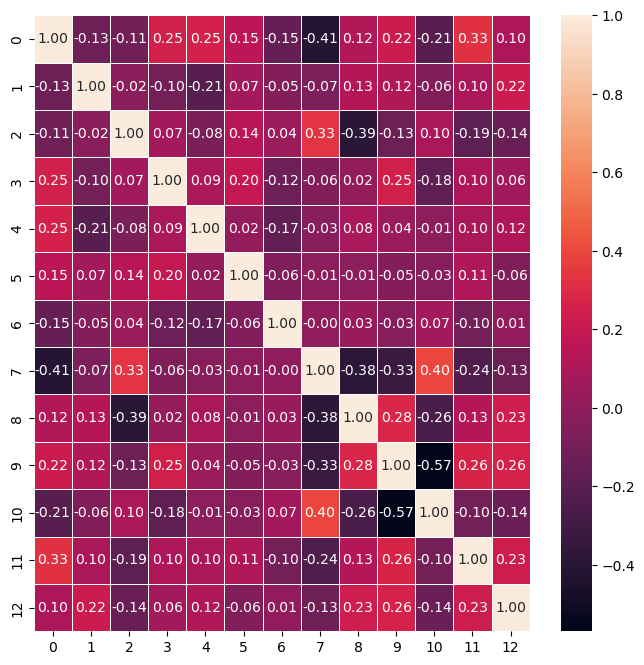

In [19]:
features_corr = plot_correlation_matrix(x_train)
x_train, x_test = exclude_correlated_features(x_train, x_test, features_corr, threshold=0.85)

exclude_low_variance_features(x_train, x_test, threshold=0.1)

# select_features_using_information_gain(x_train, y_train)

# chi2_feature_selection(x_train, y_train)

### Decision Tree

Accuracy: 72.37%
Precision: 72.73%
Recall: 78.05%
F1-score: 0.75
Matthews Correlation Coefficient (MCC): 0.44
RMSE: 0.53
R Squared: -0.11
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.72      0.66      0.69        35
           1       0.73      0.78      0.75        41

    accuracy                           0.72        76
   macro avg       0.72      0.72      0.72        76
weighted avg       0.72      0.72      0.72        76



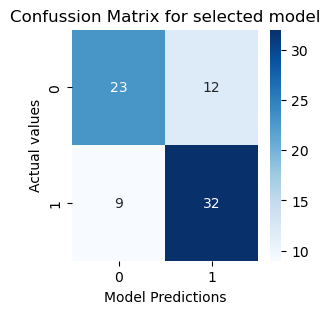

In [20]:
dt_model = DecisionTreeClassifier(random_state=11, 
                                  criterion='entropy')

dt_model.fit(x_train, y_train)
dt_acc, dt_mcc = evaluate_model(dt_model, x_test=x_test, y_test=y_test)

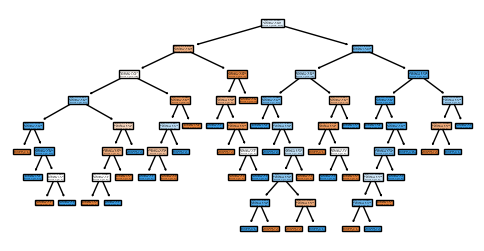

In [21]:
plot_tree_based_model(dt_model)

### Pruning Decision Tree

In [22]:
base_pdt_model = DecisionTreeClassifier(random_state=11, 
                                  criterion='entropy')
ccp_path = base_pdt_model.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = ccp_path.ccp_alphas, ccp_path.impurities

In [23]:
pdt_models = []
for ccp_alpha in ccp_alphas:
    pdt_model = DecisionTreeClassifier(random_state=11,
                                       ccp_alpha=ccp_alpha)
    pdt_model.fit(x_train, y_train)

    # add Pruning Decision Tree classifier to list of trees
    pdt_models.append(pdt_model)

In [24]:
print(f"Last tree in list has {pdt_models[-1].tree_.node_count} node for cpp_alpha parameter {ccp_alphas[-1]}")

Last tree in list has 1 for cpp_alpha parameter 0.21982887346468272


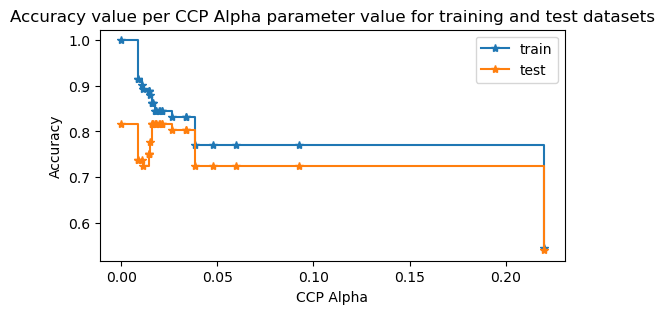

In [25]:
train_scores = [tree.score(x_train, y_train) for tree in pdt_models]
test_scores = [tree.score(x_test, y_test) for tree in pdt_models]

plot_acc_per_ccp_alpha(ccp_alphas, train_scores, test_scores)

Accuracy: 72.37%
Precision: 75.0%
Recall: 73.17%
F1-score: 0.74
Matthews Correlation Coefficient (MCC): 0.45
RMSE: 0.53
R Squared: -0.11
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.69      0.71      0.70        35
           1       0.75      0.73      0.74        41

    accuracy                           0.72        76
   macro avg       0.72      0.72      0.72        76
weighted avg       0.72      0.72      0.72        76



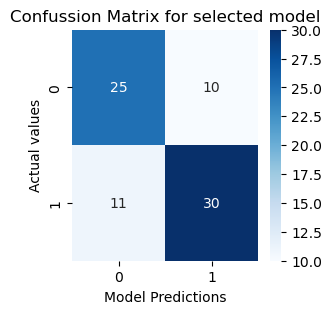

In [26]:
pdt_model = DecisionTreeClassifier(random_state=11,
                             ccp_alpha=0.02, 
                             criterion='entropy')
pdt_model.fit(x_train,y_train)
pdt_acc, pdt_mcc = evaluate_model(pdt_model, x_test=x_test, y_test=y_test)

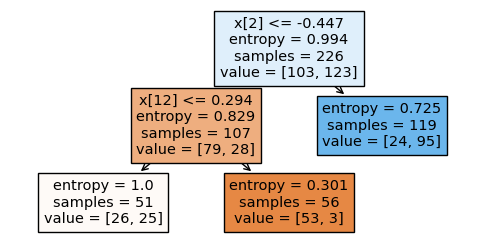

In [27]:
plot_tree_based_model(pdt_model)

### Random Forest

In [28]:
rf_base_model = RandomForestClassifier(random_state=0)
n_estimators = [10, 25, 50, 100, 250]
max_depth = [3, 5, 8, 10, 15]
max_features = ["sqrt", "log2", None, 0.5]
params = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'max_features': max_features
}

gsearch = GridSearchCV(rf_base_model,
                       param_grid=params,
                       scoring='recall')
gsearch.fit(x_train, y_train)
print(f'The best score is : {gsearch.best_score_}')
print(f'The best estimator is : {gsearch.best_estimator_}')
print(f'The best parameters is : {gsearch.best_params_}')

Accuracy: 82.89%
Precision: 81.82%
Recall: 87.8%
F1-score: 0.85
Matthews Correlation Coefficient (MCC): 0.66
RMSE: 0.41
R Squared: 0.31
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.84      0.77      0.81        35
           1       0.82      0.88      0.85        41

    accuracy                           0.83        76
   macro avg       0.83      0.82      0.83        76
weighted avg       0.83      0.83      0.83        76



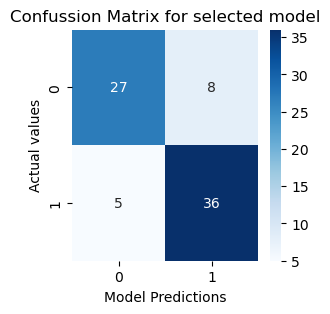

In [ ]:
rf_model = RandomForestClassifier(n_estimators=25,
                                  max_features='sqrt',
                                  random_state=0,
                                  max_depth=3)

rf_model.fit(x_train, y_train)
rf_acc, rf_mcc = evaluate_model(rf_model, x_test=x_test, y_test=y_test)

### CNN model

In [ ]:
cnn_model = Sequential()
cnn_model.add(Dense(256, 
                    input_dim=13, 
                    activation='relu'))
cnn_model.add(Dense(256, 
                    activation='relu'))
cnn_model.add(Dense(2, 
                    activation='softmax'))

cnn_model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
print(f"CNN model summary: \n{cnn_model.summary()}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               3584      
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 2)                 514       
                                                                 
Total params: 69890 (273.01 KB)
Trainable params: 69890 (273.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
CNN model summary: 
None


In [ ]:
cnn_model.fit(x_train, 
              y_cat_train, 
              epochs=10, 
              validation_data=(x_test, y_cat_test))

Epoch 1/10
8/8 [==============================] - 1s 35ms/step - loss: 0.5744 - accuracy: 0.7345 - val_loss: 0.4552 - val_accuracy: 0.8421
Epoch 2/10
8/8 [==============================] - 0s 7ms/step - loss: 0.3607 - accuracy: 0.8496 - val_loss: 0.4090 - val_accuracy: 0.8684
Epoch 3/10
8/8 [==============================] - 0s 7ms/step - loss: 0.3296 - accuracy: 0.8761 - val_loss: 0.4208 - val_accuracy: 0.8553
Epoch 4/10
8/8 [==============================] - 0s 7ms/step - loss: 0.3100 - accuracy: 0.8761 - val_loss: 0.4279 - val_accuracy: 0.8684
Epoch 5/10
8/8 [==============================] - 0s 7ms/step - loss: 0.2948 - accuracy: 0.8717 - val_loss: 0.4118 - val_accuracy: 0.8553
Epoch 6/10
8/8 [==============================] - 0s 7ms/step - loss: 0.2690 - accuracy: 0.8894 - val_loss: 0.4233 - val_accuracy: 0.8421
Epoch 7/10
8/8 [==============================] - 0s 7ms/step - loss: 0.2611 - accuracy: 0.8982 - val_loss: 0.4282 - val_accuracy: 0.8158
Epoch 8/10
8/8 [=================

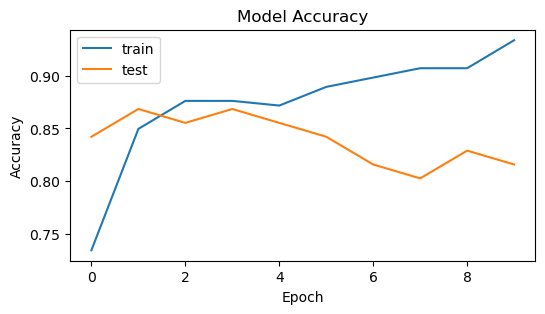

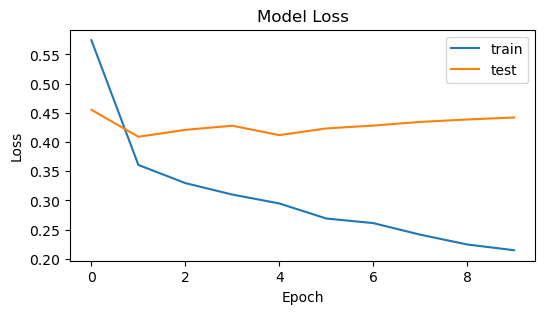

In [ ]:
plot_model_accuracy_for_epochs(cnn_model)
plot_model_loss_for_epochs(cnn_model)

In [ ]:
print(f"CNN model evaluation after training: {cnn_model.evaluate(x_train, y_cat_train)}")
print (f"CNN model evaluation for test dataset: {cnn_model.evaluate(x_test, y_cat_test)}")

8/8 [==============================] - 0s 1ms/step - loss: 0.2041 - accuracy: 0.9336
CNN model evaluation after training: [0.20408543944358826, 0.9336283206939697]
3/3 [==============================] - 0s 2ms/step - loss: 0.4420 - accuracy: 0.8158
CNN model evaluation for test dataset: [0.44202670454978943, 0.8157894611358643]


3/3 [==============================] - 0s 2ms/step
Accuracy: 81.58%
Precision: 82.93%
Recall: 82.93%
F1-score: 0.83
Matthews Correlation Coefficient (MCC): 0.63
RMSE: 0.43
R Squared: 0.26
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        35
           1       0.83      0.83      0.83        41

    accuracy                           0.82        76
   macro avg       0.81      0.81      0.81        76
weighted avg       0.82      0.82      0.82        76



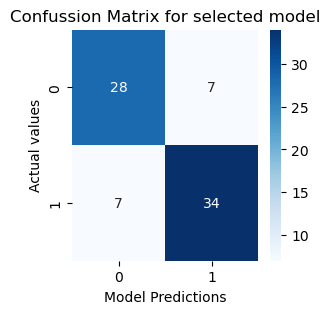

In [ ]:
cnn_acc, cnn_mcc = evaluate_model(cnn_model, x_test=x_test, y_test=y_test, is_cnn=True)

### Logistic Regression

Accuracy: 85.53%
Precision: 82.61%
Recall: 92.68%
F1-score: 0.87
Matthews Correlation Coefficient (MCC): 0.71
RMSE: 0.38
R Squared: 0.42
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.90      0.77      0.83        35
           1       0.83      0.93      0.87        41

    accuracy                           0.86        76
   macro avg       0.86      0.85      0.85        76
weighted avg       0.86      0.86      0.85        76



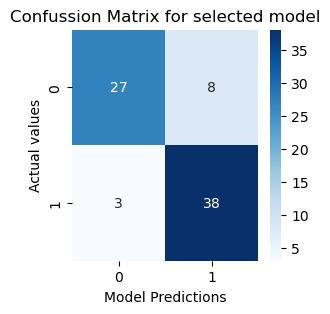

In [ ]:
lr_model = LogisticRegression(random_state=0, C=10, penalty='l2')
lr_model.fit(x_train, y_train)
lr_acc, lr_mcc = evaluate_model(lr_model, x_test=x_test, y_test=y_test)

### Support Vector Machine

Accuracy: 86.84%
Precision: 82.98%
Recall: 95.12%
F1-score: 0.89
Matthews Correlation Coefficient (MCC): 0.74
RMSE: 0.36
R Squared: 0.47
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.93      0.77      0.84        35
           1       0.83      0.95      0.89        41

    accuracy                           0.87        76
   macro avg       0.88      0.86      0.87        76
weighted avg       0.88      0.87      0.87        76



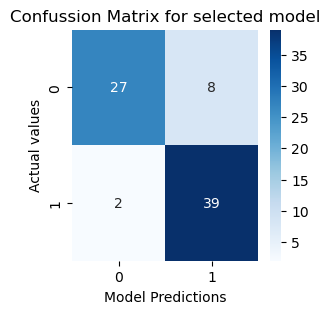

In [ ]:
svm_model = SVC(kernel='linear', C=0.3)
svm_model.fit(x_train, y_train)
svm_acc, svm_mcc = evaluate_model(svm_model, x_test=x_test, y_test=y_test)

### K Nearest Neighbours

Accuracy: 84.21%
Precision: 83.72%
Recall: 87.8%
F1-score: 0.86
Matthews Correlation Coefficient (MCC): 0.68
RMSE: 0.4
R Squared: 0.36
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.85      0.80      0.82        35
           1       0.84      0.88      0.86        41

    accuracy                           0.84        76
   macro avg       0.84      0.84      0.84        76
weighted avg       0.84      0.84      0.84        76



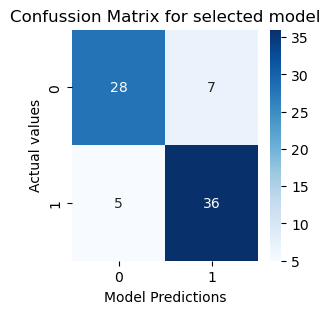

In [ ]:
knn_model = KNeighborsClassifier(leaf_size=1, n_neighbors=3)
knn_model.fit(x_train, y_train)
knn_acc, knn_mcc = evaluate_model(knn_model, x_test=x_test, y_test=y_test)

### Gaussian Naive Bayes

Accuracy: 81.58%
Precision: 80.0%
Recall: 87.8%
F1-score: 0.84
Matthews Correlation Coefficient (MCC): 0.63
RMSE: 0.43
R Squared: 0.26
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.84      0.74      0.79        35
           1       0.80      0.88      0.84        41

    accuracy                           0.82        76
   macro avg       0.82      0.81      0.81        76
weighted avg       0.82      0.82      0.81        76



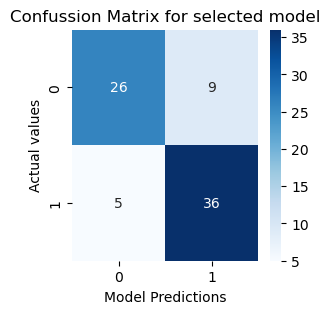

In [ ]:
gnb_model = GaussianNB()
gnb_model.fit(x_train, y_train)
gnb_acc, gnb_mcc = evaluate_model(gnb_model, x_test=x_test, y_test=y_test)

### XGBoost Classifier

Accuracy: 76.32%
Precision: 79.49%
Recall: 75.61%
F1-score: 0.77
Matthews Correlation Coefficient (MCC): 0.53
RMSE: 0.49
R Squared: 0.05
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.73      0.77      0.75        35
           1       0.79      0.76      0.77        41

    accuracy                           0.76        76
   macro avg       0.76      0.76      0.76        76
weighted avg       0.76      0.76      0.76        76



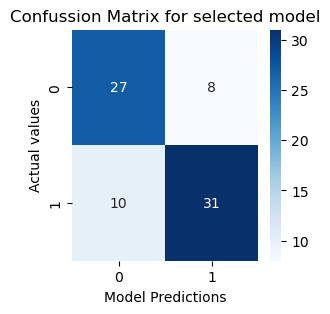

In [ ]:
xgb_model = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
xgb_model.fit(x_train, y_train)
xgb_acc, xgb_mcc = evaluate_model(xgb_model, x_test=x_test, y_test=y_test)

Accuracy: 84.21%
Precision: 83.72%
Recall: 87.8%
F1-score: 0.86
Matthews Correlation Coefficient (MCC): 0.68
RMSE: 0.4
R Squared: 0.36
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.85      0.80      0.82        35
           1       0.84      0.88      0.86        41

    accuracy                           0.84        76
   macro avg       0.84      0.84      0.84        76
weighted avg       0.84      0.84      0.84        76



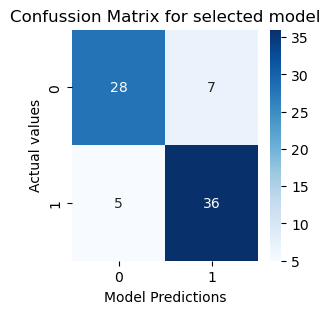

In [ ]:
cb_model = CatBoostClassifier(verbose=False)
cb_model.fit(x_train, y_train)
cb_acc, cb_mcc = evaluate_model(cb_model, x_test=x_test, y_test=y_test)

### LightGBM Classifier

In [ ]:
# lgbm_model = LGBMClassifier()
# lgbm_model.fit(x_train, y_train)
# lgbm_acc, lgb,_mcc = evaluate_model(lgbm_model, x_test=x_test, y_test=y_test)

### Comparison of models' results

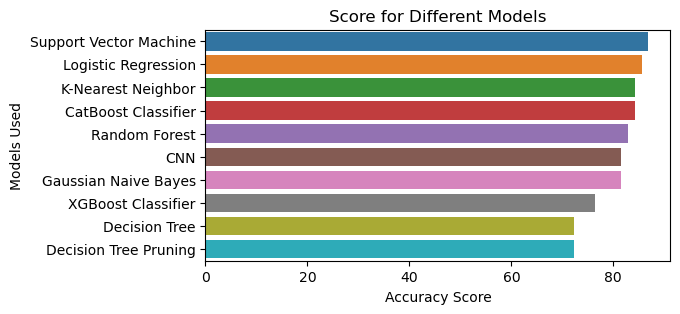

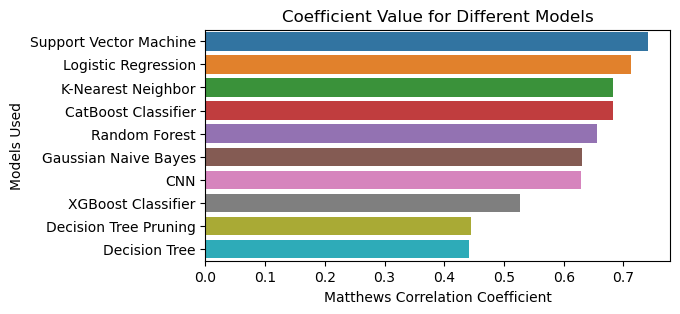

In [ ]:
acc_scores = {
    'Decision Tree': dt_acc * 100, 
    'Decision Tree Pruning': pdt_acc * 100, 
    'Random Forest': rf_acc * 100, 
    'Logistic Regression': lr_acc * 100,
    'Support Vector Machine': svm_acc * 100, 
    'K-Nearest Neighbor': knn_acc * 100,
    'CNN': cnn_acc * 100,
    'Gaussian Naive Bayes': gnb_acc * 100,
    'XGBoost Classifier': xgb_acc * 100,
    'CatBoost Classifier': cb_acc * 100
}

mcc_scores = {
    'Decision Tree': dt_mcc, 
    'Decision Tree Pruning': pdt_mcc, 
    'Random Forest': rf_mcc, 
    'Logistic Regression': lr_mcc,
    'Support Vector Machine': svm_mcc, 
    'K-Nearest Neighbor': knn_mcc,
    'CNN': cnn_mcc,
    'Gaussian Naive Bayes': gnb_mcc,
    'XGBoost Classifier': xgb_mcc,
    'CatBoost Classifier': cb_mcc
}

plot_acc_overview(acc_scores)
plot_mcc_overview(mcc_scores)